In [1]:
#cargamos las bibliotecas y la data
!pip install pmdarima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import meanabs
import itertools
import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.0 MB/s eta 0:00:00


In [3]:
data = pd.read_excel('Sales_Data.xlsx')

data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Order Date'].min(), data['Order Date'].max()


(Timestamp('2015-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00'))

In [4]:
data.set_index('Order Date', inplace=True)
data.head()

,Sales
Order Date,
2015-01-01,14205.707
2015-02-01,4519.892
2015-03-01,55205.797
2015-04-01,27906.855
2015-05-01,23644.303


<Axes: xlabel='Order Date'>

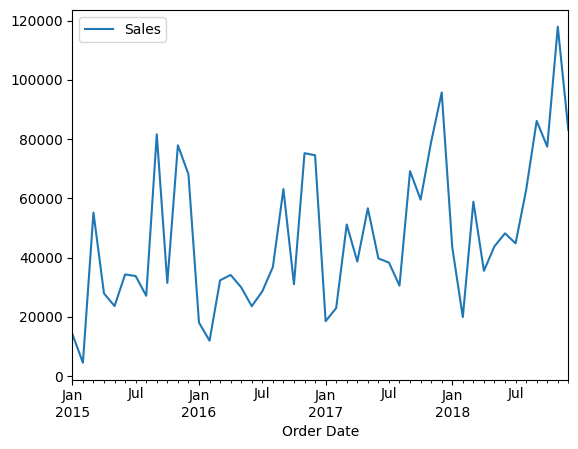

In [5]:
data.plot()

# Componentes de la Serie de Tiempo

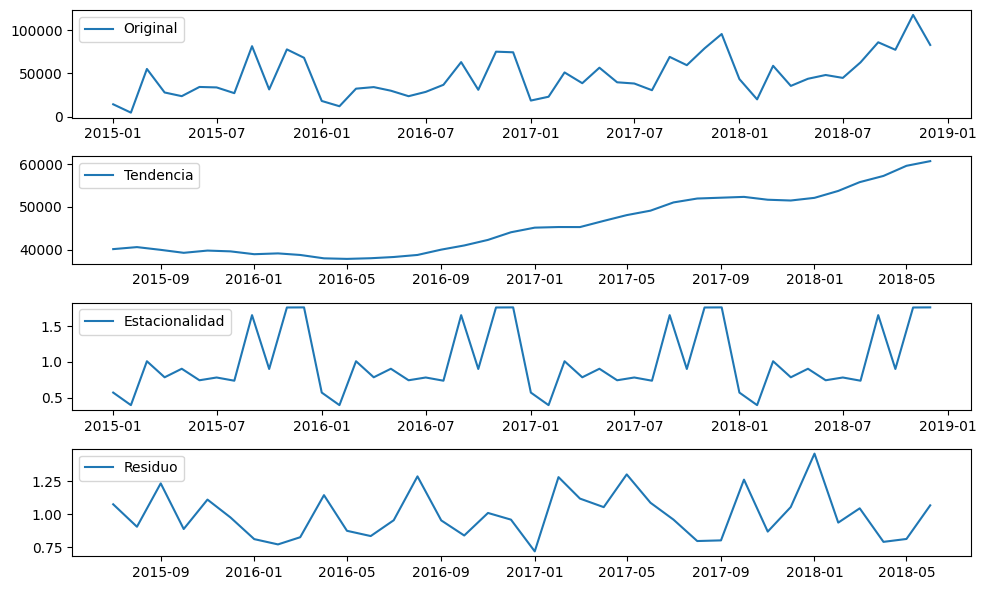

In [134]:
# Descomposición de la serie de tiempo en componentes
result = seasonal_decompose(data, model='multiplicative')
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Mostrar los componentes descompuestos
plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuo')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#Split Data

In [7]:
# Separar los datos en entrenamiento y prueba
train_data = data[:-12]
test_data = data[-12:]

In [8]:
train_data.tail(3)

,Sales
Order Date,
2017-10-01,59583.0330
2017-11-01,79066.4958
2017-12-01,95739.1210


In [9]:
test_data.head(3)

,Sales
Order Date,
2018-01-01,43476.4740
2018-02-01,19920.9974
2018-03-01,58863.4128


#Modelado de la serie temporal

##Modelo ARIMA en función de 'adf test' y gráficas 'acf' y 'pacf'



###Determinación de parámetros p,d,q
Estacionaria - Dickey-Fuller

In [10]:
def adf_test(data):
    d = 0
    diff_data = data.copy()
    dftest = adfuller(data, autolag = 'AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", round(dftest[1],6))
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
       print("\t",key, ": ", val)
    if dftest[0] < dftest[4]["5%"]:
        print (" Reject Ho - Time Series is Stationary")
        print(f" Number of differencing needed 'd': {d}")
    else:
        print ("\n Failed to Reject Ho - Time Series is Non-Stationary")
        p_value = dftest[1]
        while  p_value > 0.05:
          diff_data = data.diff()
          p_value = adfuller(diff_data.dropna())[1]
          d += 1
        print(f" Number of differencing needed 'd': {d}")
    return diff_data


diff_data = adf_test(data['Sales'])

1. ADF :  -4.416136761430769
2. P-Value :  0.000278
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 47
5. Critical Values :
	 1% :  -3.5778480370438146
	 5% :  -2.925338105429433
	 10% :  -2.6007735310095064
 Reject Ho - Time Series is Stationary
 Number of differencing needed 'd': 0


PACF Plot

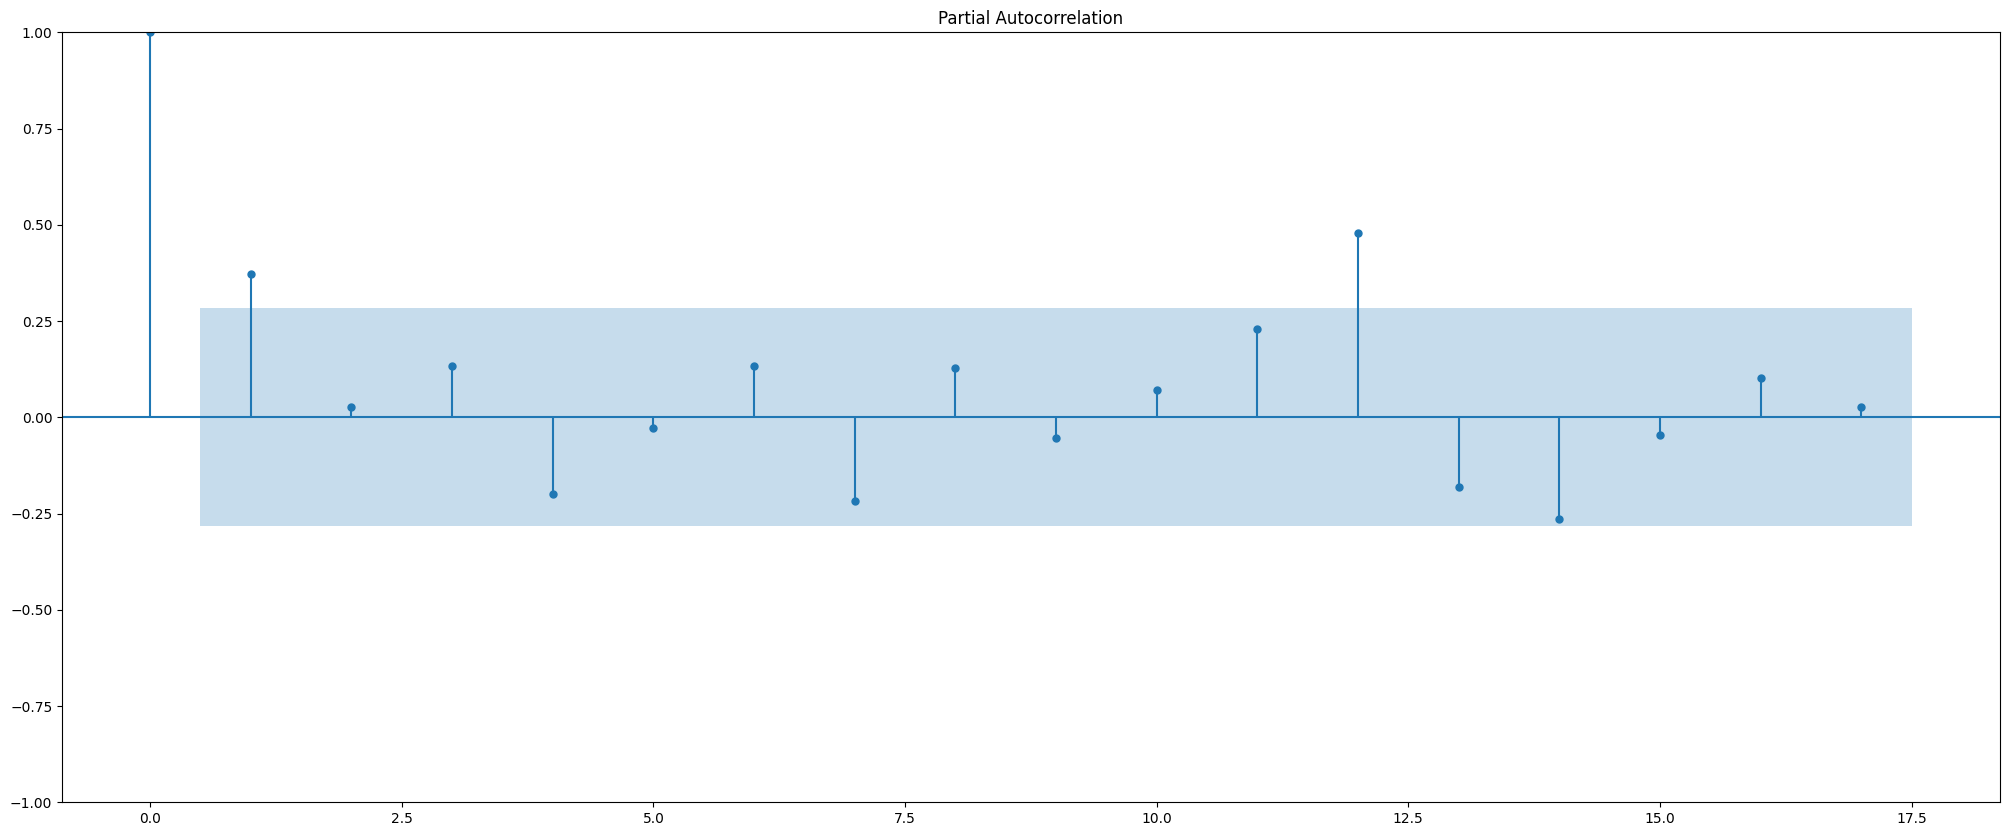

In [11]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_pacf(diff_data.dropna(), ax=ax)
plt.show()

ACF Plot

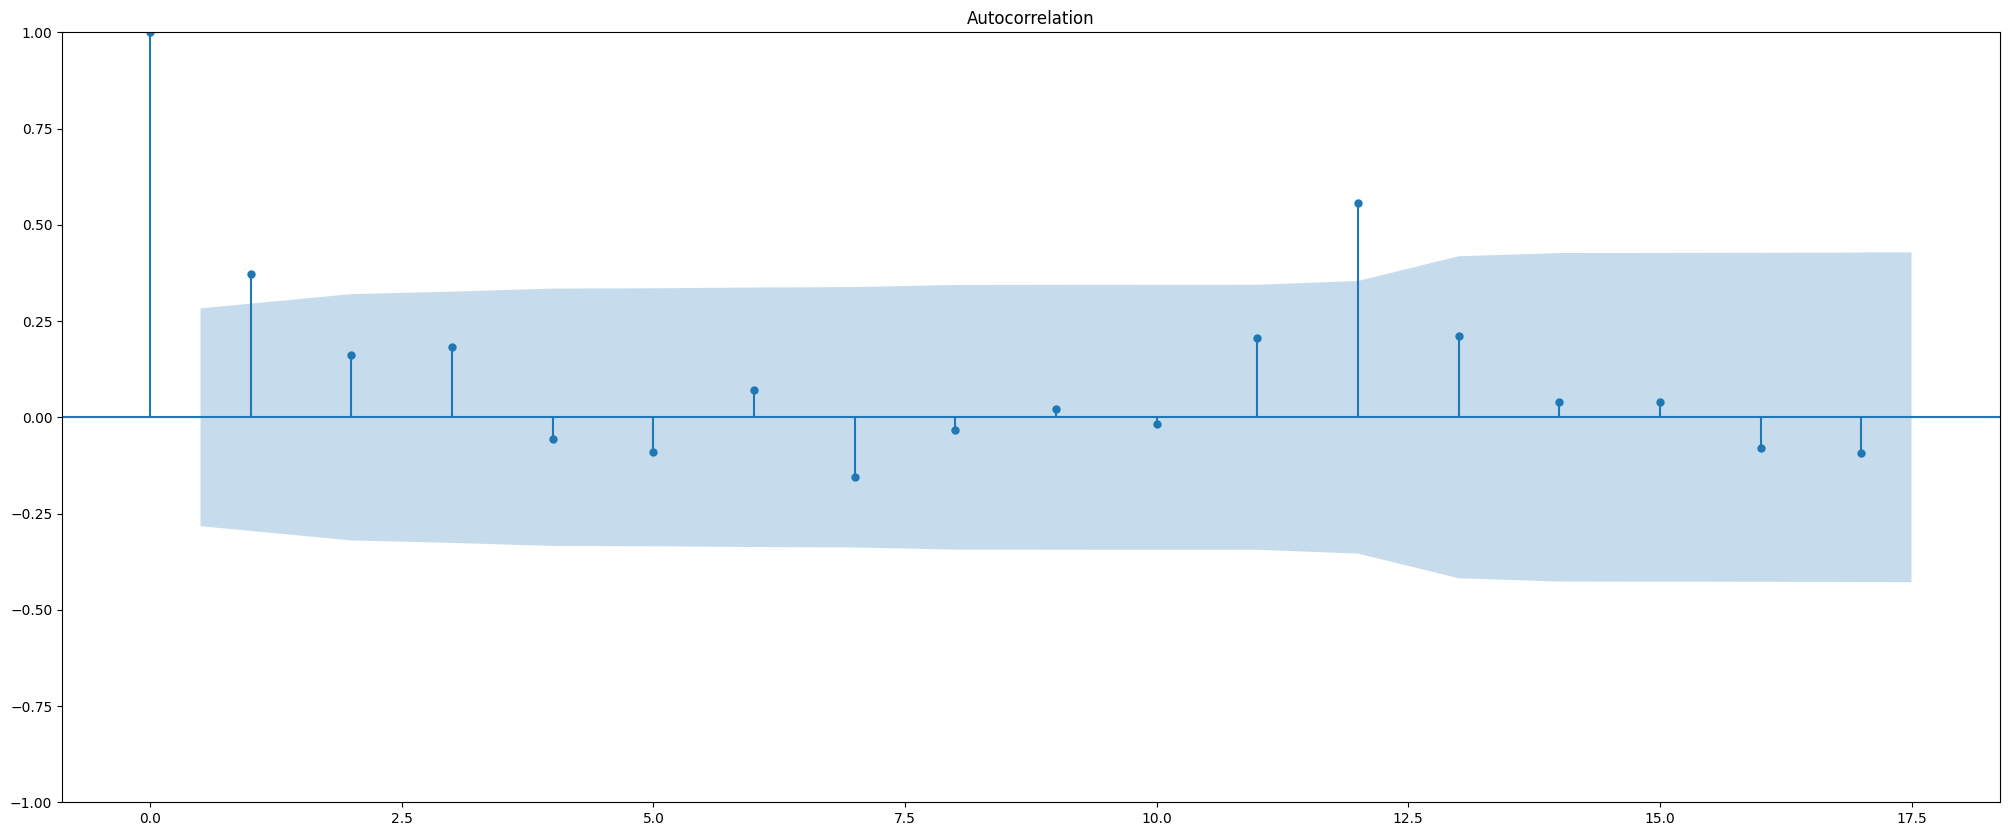

In [12]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_acf(diff_data.dropna(), ax=ax)
plt.show()

###Modelado con ARIMA

In [360]:
model_arima_plot = ARIMA(train_data, order=(12, 0, 12),
                          enforce_stationarity=False,
                          enforce_invertibility=False,
                          trend='c')
model_arima_plot = model_arima_plot.fit()


In [361]:
model_arima_plot.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:               ARIMA(12, 0, 12)   Log Likelihood                -248.921
Date:                Tue, 11 Mar 2025   AIC                            549.842
Time:                        14:55:18   BIC                            579.365
Sample:                    01-01-2015   HQIC                           557.267
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.276e+04      0.009   4.78e+06      0.000    4.28e+04    4.28e+04
ar.L1          0.2854     13.641      0.021      0.983     -26.450      27.021
ar.L2         -0.0758     10.663     -0.007      0.994     -20.975      20.824
ar.L3          0.3054     16.551      0.018      0.985     -32.135      32.746
ar.L4         -0.1685     11.358     -0.015      0.988     -22.431      22.093
ar.L5          0.2373      7.538      0.031      0.975     -14.538      15.012
ar.L6          0.2363     20.741      0.011      0.991     -40.416      40.889
ar.L7         -0.0454     10.615     -0.004      0.997     -20.850      20.760
ar.L8          0.1573     17.639      0.009      0.993     -34.415      34.729
ar.L9         -0.2849      8.540     -0.033      0.973     -17.023      16.453
ar.L10         0.3553     19.224      0.018      0.985     -37.323      38.033
ar.L11        -0.2846     13.004     -0.022      0.983     -25.772      25.202
ar.L12         1.1149     11.251      0.099      0.921     -20.936      23.166
ma.L1          0.3363     21.117      0.016      0.987     -41.052      41.725
ma.L2          0.8679     26.964      0.032      0.974     -51.980      53.716
ma.L3          0.4661     28.067      0.017      0.987     -54.545      55.477
ma.L4          0.6687     31.115      0.021      0.983     -60.316      61.653
ma.L5          0.0155     28.401      0.001      1.000     -55.649      55.680
ma.L6         -0.3057     21.838     -0.014      0.989     -43.107      42.496
ma.L7          0.1416     14.356      0.010      0.992     -27.995      28.279
ma.L8          0.0558     50.717      0.001      0.999     -99.347      99.459
ma.L9          0.1803     32.343      0.006      0.996     -63.210      63.571
ma.L10        -0.0690     46.763     -0.001      0.999     -91.724      91.586
ma.L11         0.5688     23.764      0.024      0.981     -46.008      47.145
ma.L12        -0.0710     29.573     -0.002      0.998     -58.033      57.891
sigma2      3.876e+08   1.68e-05    2.3e+13      0.000    3.88e+08    3.88e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.84   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.09   Prob(JB):                         0.96
Heteroskedasticity (H):               1.77   Skew:                            -0.10
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.68e+29. Standard errors may be unstable.
"""

###Predicción

In [363]:
#in-sample forecasts
is_forecast_arima_plot = model_arima_plot.get_prediction(start=pd.to_datetime('2015-01-01'),dynamic=False)
#out-of-sample forecasts
oos_forecast_arima_plot = model_arima_plot.get_prediction(start=pd.to_datetime('2018-01-01'), end=pd.to_datetime('2018-12-01'),dynamic=False)

#forecasted values stored in is_forecast_arima_plot.predicted_mean, oos_forecast_arima_plot.predicted_mean
#conf_int contains the confidence intervals
is_forecasts_ci = is_forecast_arima_plot.conf_int()
oos_forecasts_ci = oos_forecast_arima_plot.conf_int()

###Visualización

In [271]:
def visualization(data, model_name, is_forecasted, oos_forecasted, is_forecasts_ci, oos_forecasts_ci):
  ax = data.plot(label='observed')
  is_forecasted.plot(ax=ax, label=f'In-sample forecast({model_name})', alpha=.7, figsize=(14, 5))
  oos_forecasted.plot(ax=ax, label=f'Out-of-sample forecast({model_name})', alpha=.7, figsize=(14, 5))
  ax.fill_between(is_forecasts_ci.index,
                is_forecasts_ci.iloc[:, 0],
                is_forecasts_ci.iloc[:, 1], color='k', alpha=.2)
  ax.fill_between(oos_forecasts_ci.index,
                oos_forecasts_ci.iloc[:, 0],
                oos_forecasts_ci.iloc[:, 1], color='k', alpha=.2)
  ax.set_xlabel('Date')
  ax.set_ylabel('Sales')
  plt.title('Sales Predictions vs Actual')
  plt.legend(loc= 'lower right')
  plt.show()


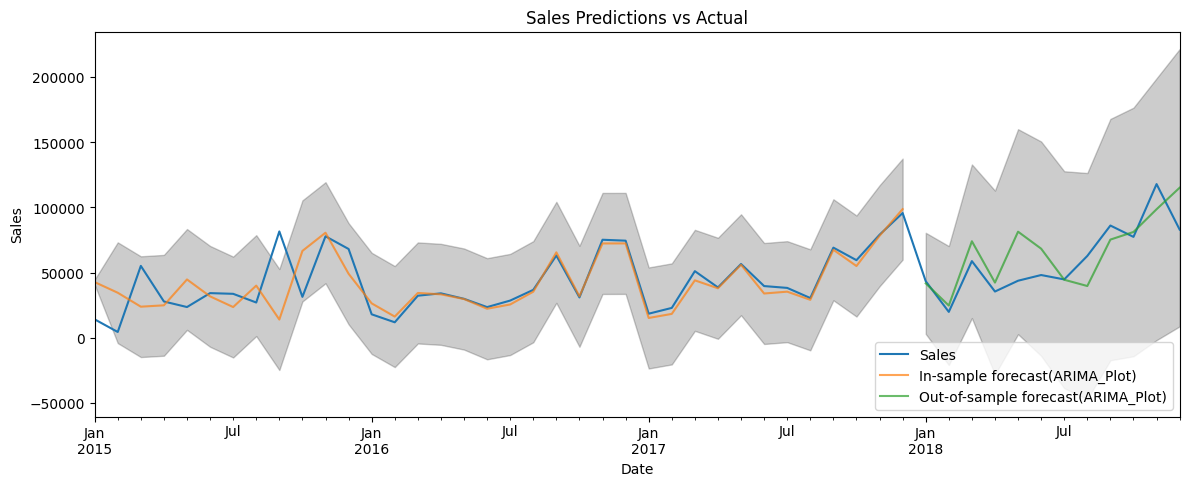

In [365]:
visualization(data, 'ARIMA_Plot', is_forecast_arima_plot.predicted_mean, oos_forecast_arima_plot.predicted_mean, is_forecasts_ci, oos_forecasts_ci)

###Evaluación

In [297]:
def evaluate_model(predictions, test):
    mse = mean_squared_error(test, predictions)
    rmse = round(np.sqrt(mse),2)
    mape = round(((meanabs(test, predictions) / np.mean(np.abs(test))) * 100).mean(),2)
    return rmse, mape

In [367]:
rmse_arima_plot, mape_arima_plot = evaluate_model(oos_forecast_arima_plot.predicted_mean.values, test_data)

print('The Root Mean Squared Error of our forecasts is {}'.format(rmse_arima_plot))
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(mape_arima_plot))

The Root Mean Squared Error of our forecasts is 18699.51
The Mean Absolute Percentage Error of our forecasts is 49.31


##GridSearch

###Modelo ARIMA, optimización GridSearch

In [347]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

In [348]:
bestAIC = np.inf
bestModel = None
for param in pdq:
    print('param:',param)
    try:
        model = ARIMA(train_data,
                      order=param,
                      enforce_stationarity=False,
                      enforce_invertibility=False,
                      trend='c')
        results = model.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))

        if results.aic < bestAIC:
            bestAIC = results.aic
            bestModel = results
            print('****BEST****')
    except:
        continue

param: (0, 0, 0)
ARIMA(0, 0, 0) - AIC:896.9147513269205
****BEST****
param: (0, 0, 1)
ARIMA(0, 0, 1) - AIC:780.9035235848366
****BEST****
param: (0, 0, 2)
ARIMA(0, 0, 2) - AIC:760.2926922812761
****BEST****
param: (0, 1, 0)
param: (0, 1, 1)
param: (0, 1, 2)
param: (0, 2, 0)
param: (0, 2, 1)
param: (0, 2, 2)
param: (1, 0, 0)
ARIMA(1, 0, 0) - AIC:804.6613774043074
param: (1, 0, 1)
ARIMA(1, 0, 1) - AIC:782.7296121569563
param: (1, 0, 2)
ARIMA(1, 0, 2) - AIC:758.6397488261665
****BEST****
param: (1, 1, 0)
param: (1, 1, 1)
param: (1, 1, 2)
param: (1, 2, 0)
param: (1, 2, 1)
param: (1, 2, 2)
param: (2, 0, 0)
ARIMA(2, 0, 0) - AIC:782.7164098801859
param: (2, 0, 1)
ARIMA(2, 0, 1) - AIC:781.7951172031632
param: (2, 0, 2)
ARIMA(2, 0, 2) - AIC:760.6179941712912
param: (2, 1, 0)
param: (2, 1, 1)
param: (2, 1, 2)
param: (2, 2, 0)
param: (2, 2, 1)
param: (2, 2, 2)


In [350]:
bestModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -374.320
Date:                Tue, 11 Mar 2025   AIC                            758.640
Time:                        14:53:08   BIC                            766.122
Sample:                    01-01-2015   HQIC                           761.157
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.276e+04   2844.709     15.033      0.000    3.72e+04    4.83e+04
ar.L1          0.7207      0.107      6.709      0.000       0.510       0.931
ma.L1         -0.7213      0.258     -2.792      0.005      -1.228      -0.215
ma.L2         -0.4011      0.241     -1.667      0.095      -0.873       0.070
sigma2      5.134e+08      0.004   1.23e+11      0.000    5.13e+08    5.13e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 4.35
Prob(Q):                              0.84   Prob(JB):                         0.11
Heteroskedasticity (H):               0.97   Skew:                             0.88
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.35e+28. Standard errors may be unstable.
"""

###Predicciones

In [352]:
#in-sample forecasts
is_forecasts = bestModel.get_prediction(start=pd.to_datetime('2015-01-01'),dynamic=False)
#out-of-sample forecasts
oos_forecasts = bestModel.get_prediction(start=pd.to_datetime('2018-01-01'), end=pd.to_datetime('2018-12-01'),dynamic=False)

#forecasted values stored in is_forecasts.predicted_mean, oos_forecasts.predicted_mean
#conf_int contains the confidence intervals
is_forecasts_ci = is_forecasts.conf_int()
oos_forecasts_ci = oos_forecasts.conf_int()

###Visualización

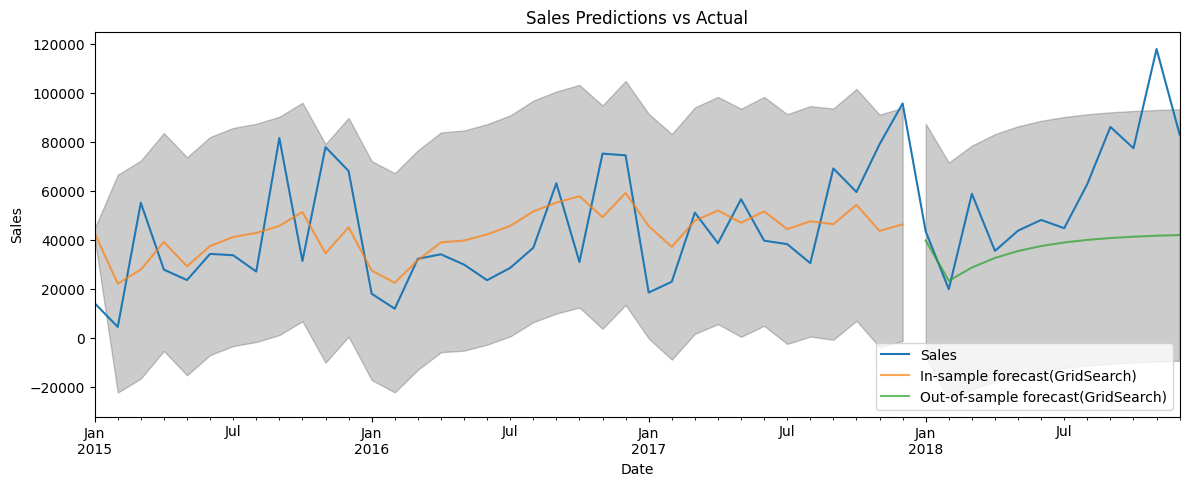

In [353]:
visualization(data, 'GridSearch', is_forecasts.predicted_mean, oos_forecasts.predicted_mean, is_forecasts_ci, oos_forecasts_ci)

###Evaluación

In [356]:
rmse_gridsearch, mape_gridsearch = evaluate_model(oos_forecasts.predicted_mean.values, test_data)

print('The Root Mean Squared Error of our forecasts is {}'.format(rmse_gridsearch))
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(mape_gridsearch))

The Root Mean Squared Error of our forecasts is 32302.71
The Mean Absolute Percentage Error of our forecasts is 44.28


##AutoARIMA

### Modelo AutoARIMA

In [390]:
auto_model = auto_arima(train_data, start_p=1, start_q=1,
                            test = 'kpss',
                            max_p=3, max_q=3,
                            m=1,
                            d=None,
                            seasonal=False,
                            start_P=0,
                            D=None,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=832.717, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=880.891, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=839.566, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=868.157, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=834.145, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=834.648, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=868.688, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=836.398, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=836.481, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=830.095, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=828.310, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=828.436, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=830.560, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=828.162, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=830.3

In [379]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -411.081
Date:                Tue, 11 Mar 2025   AIC                            828.162
Time:                        15:04:02   BIC                            832.913
Sample:                    01-01-2015   HQIC                           829.820
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.239e+04   7843.452      4.130      0.000     1.7e+04    4.78e+04
ar.L1          0.2514      0.155      1.625      0.104      -0.052       0.555
sigma2      4.745e+08      0.101    4.7e+09      0.000    4.75e+08    4.75e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.53
Prob(Q):                              0.96   Prob(JB):                         0.28
Heteroskedasticity (H):               0.81   Skew:                             0.47
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.93e+30. Standard errors may be unstable.
"""

###Predicción

In [400]:
#in-sample forecasts
auto_is_forecasts, auto_is_forecasts_ci = auto_model.predict_in_sample(return_conf_int=True)
#we convert to series to facilitate the generation of graphs
auto_is_forecasts = pd.Series(auto_is_forecasts, index=train_data.index)
auto_is_forecasts_ci = pd.DataFrame(auto_is_forecasts_ci,index=train_data.index)

#out-of-sample forecasts
auto_oos_forecasts, auto_oos_forecasts_ci = auto_model.predict(n_periods = 12, return_conf_int=True)
#we convert to series to facilitate the generation of graphs
auto_oos_forecasts = pd.Series(auto_oos_forecasts, index=test_data.index)
auto_oos_forecasts_ci = pd.DataFrame(auto_oos_forecasts_ci,index=test_data.index)

###Visualización

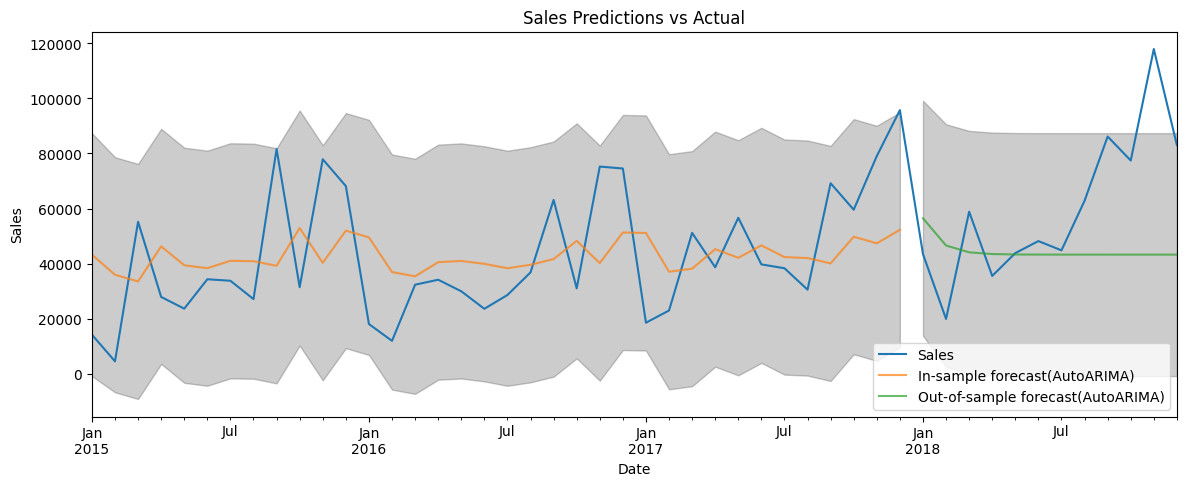

In [401]:
visualization(data, 'AutoARIMA', auto_is_forecasts, auto_oos_forecasts, auto_is_forecasts_ci, auto_oos_forecasts_ci)

###Evaluación

In [403]:
rmse_auto_model, mape_auto_model = evaluate_model(auto_oos_forecasts.values, test_data)

print('The Root Mean Squared Error of our forecasts is {}'.format(rmse_auto_model))
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(mape_auto_model))

The Root Mean Squared Error of our forecasts is 31268.55
The Mean Absolute Percentage Error of our forecasts is 36.32


# Reporte comparativo

In [405]:
#Comparemos las métricas obtenidas para los diferentes modelos
metrics = {'ARIMA_Plot':[rmse_arima_plot,  mape_arima_plot, model_arima_plot.aic ],
          'GridSearch':[rmse_gridsearch, mape_gridsearch, bestModel.aic],
          'AutoARIMA':[rmse_auto_model,  mape_auto_model, '828.162']}

df_metrics = pd.DataFrame(metrics, index=['RMSE', 'MAPE', 'AIC'])
df_metrics


,ARIMA_Plot,GridSearch,AutoARIMA
RMSE,18699.510000,32302.710000,31268.55
MAPE,49.310000,44.280000,36.32
AIC,549.841838,758.639749,828.162
